# Simple Classifier / Logistic Regression

This notebook will demosntrate a simple logistic regression model predicting whether a house is ```low-priced``` or ```expensive```. Similar to our linear model in ```1_linear_regression.ipynb```, we feed features from the HousingPrice dataset into the classifier model. However, now, we expect our model to output a score that determines in which category the considered house is. 
![classifierTeaser](images/classifierTeaser.png)

$ $ Let $\mathbf{X} \in \mathbb{R}^{N\times (D+1)}$ denote our data with $N$ samples and $D$ feature dimensions. Our targets, the binary labels, are given by $\mathbf{y} \in \mathbb{R}^{N\times 1}$. We want to estimate them with a simple classifier of the form

$$ \mathbf{y}  = \sigma \left( \mathbf{X} \mathbf{w} \right), $$ 

$ $ where $\mathbf{w}\in \mathbb{R}^{(D+1) \times 1}$ is the weight of our classifier. The sigmoid function $\sigma: \mathbb{R} \to [0, 1]$, defined by 

$$ \sigma(t) = \frac{1}{1+\mathrm{exp}(-t)}, $$

is used to squeeze the ouputs of the linear layer into the range $[0, 1]$. This provides us with a probabilistic interpretation of the ouput of the neural network and we can compute the label predictions by rounding the output.

<img src="https://miro.medium.com/max/2400/1*RqXFpiNGwdiKBWyLJc_E7g.png" width="800">

In [2]:
from exercise_code.data.csv_dataset import CSVDataset
from exercise_code.data.csv_dataset import FeatureSelectorAndNormalizationTransform
from exercise_code.data.dataloader import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns


pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib inline
%load_ext autoreload
%autoreload 2

## 1. Load your data

We apply the same dataloading and preprocessing steps as in the notebook ```1_linear_regression.ipynb```.

In [3]:
target_column = 'SalePrice'
i2dl_exercises_path = os.path.dirname(os.path.abspath(os.getcwd()))
root_path = os.path.join(i2dl_exercises_path, "datasets", 'housing')
housing_file_path = os.path.join(root_path, "housing_train.csv")
download_url = 'https://cdn3.vision.in.tum.de/~dl4cv/housing_train.zip'

# Always make sure this line was run at least once before trying to
# access the data manually, as the data is downloaded in the 
# constructor of CSVDataset.
train_dataset = CSVDataset(target_column=target_column, root=root_path, download_url=download_url, mode="train")

For the data transformations, compute min, max and mean for each feature column. We perform the same transformation on the training, validation, and test data.

In [4]:
df = train_dataset.df
# Select only 2 features to keep plus the target column.
#selected_columns = ['OverallQual', 'GrLivArea', target_column]
selected_columns = ['GrLivArea', target_column]
mn, mx, mean = df.min(), df.max(), df.mean()

column_stats = {}
for column in selected_columns:
    crt_col_stats = {'min' : mn[column],
                     'max' : mx[column],
                     'mean': mean[column]}
    column_stats[column] = crt_col_stats    

transform = FeatureSelectorAndNormalizationTransform(column_stats, target_column)

def rescale(data, key = "SalePrice", column_stats = column_stats):
    """ Rescales input series y"""
    mx = column_stats[key]["max"]
    mn = column_stats[key]["min"]

    return data * (mx - mn) + mn


In [5]:
# Always make sure this line was run at least once before trying to
# access the data manually, as the data is downloaded in the 
# constructor of CSVDataset.
train_dataset = CSVDataset(mode="train", target_column=target_column, root=root_path, download_url=download_url, transform=transform)
val_dataset = CSVDataset(mode="val", target_column=target_column, root=root_path, download_url=download_url, transform=transform)
test_dataset = CSVDataset(mode="test", target_column=target_column, root=root_path, download_url=download_url, transform=transform)


print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))
print("Number of test samples:", len(test_dataset))

Number of training samples: 876
Number of validation samples: 292
Number of test samples: 292


In [6]:
# load training data into a matrix of shape (N, D), same for targets resulting in the shape (N, 1)
X_train = [train_dataset[i]['features'] for i in range((len(train_dataset)))]
X_train = np.stack(X_train, axis=0)
y_train = [train_dataset[i]['target'] for i in range((len(train_dataset)))]
y_train = np.stack(y_train, axis=0)
print("train data shape:", X_train.shape)
print("train targets shape:", y_train.shape)

# load validation data
X_val = [val_dataset[i]['features'] for i in range((len(val_dataset)))]
X_val = np.stack(X_val, axis=0)
y_val = [val_dataset[i]['target'] for i in range((len(val_dataset)))]
y_val = np.stack(y_val, axis=0)
print("val data shape:", X_val.shape)
print("val targets shape:", y_val.shape)

# load train data
X_test = [test_dataset[i]['features'] for i in range((len(test_dataset)))]
X_test = np.stack(X_test, axis=0)
y_test = [test_dataset[i]['target'] for i in range((len(test_dataset)))]
y_test = np.stack(y_test, axis=0)
print("test data shape:", X_val.shape)
print("test targets shape:", y_val.shape)


# 0 encodes small prices, 1 encodes large prices.

train data shape: (876, 1)
train targets shape: (876, 1)
val data shape: (292, 1)
val targets shape: (292, 1)
test data shape: (292, 1)
test targets shape: (292, 1)


In the following, we model the regression task as a binary classification problem in the categories ```low-priced```and ```expensive``` by labeling the 30% of the houses that are sold with the lowest price with ```0``` and, accordingly, the 30% of the houses with the highest price with ```1```.

In [7]:
from exercise_code.networks.utils import binarize
y_all = np.concatenate([y_train, y_val, y_test])
thirty_percentile = np.percentile(y_all, 30)
seventy_percentile = np.percentile(y_all, 70)

# Prepare the labels for classification.
X_train, y_train = binarize(X_train, y_train, thirty_percentile, seventy_percentile )
X_val, y_val   = binarize(X_val, y_val, thirty_percentile, seventy_percentile)
X_test, y_test  = binarize(X_test, y_test, thirty_percentile, seventy_percentile)

## 1. Set up a classfier model

We define a simple classifier in ```exercise_code/networks/classifier.py```. Implement the forward pass in method ```forward()``` and the backward pass in ```backward()``` in the Network class ```Classifier```. This time, you also need to implement the function ```sigmoid()```.

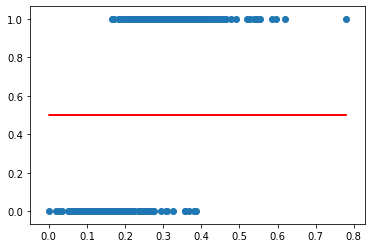

In [8]:
from exercise_code.networks.classifier import Classifier

model = Classifier(num_features=1)
model.initialize_weights()

y_out, _ = model(X_train)

# plot the prediction
plt.scatter(X_train, y_train)
plt.plot(X_train, y_out, color='r')

## 2. Implement the Loss Function: Binary Cross Entropy


In this part, you will implement a binary cross entropy (BCE) loss function. Open the file `exercise_code/networks/loss.py` and implement the forward and backward pass of BCE loss into the `forward` and `backward` function.

Remember the BCE loss function is:
$$ bce = -\hat y log(y) - (1- \hat y) log(1-y)$$

$ $ where $y$ is the output of your model, and $\hat y$ is the ground truth of the data

In [9]:
from exercise_code.networks.loss import BCE

bce_loss = BCE()


## Forward and Backward Check

Once you have finished implementation of BCE loss class, you can run the following code to check whether your forward result and backward gradient are correct. You should expect your relative error to be lower than 1e-8.

Here we will use a numeric gradient check to debug the backward pass:

$$ \frac {df(x)}{dx} = \frac{f(x+h) - f(x-h)}{2h} $$

where $h$ is a very small number, in practice approximately 1e-5 or so.

In [10]:
from exercise_code.tests.loss_tests import *
print (BCETest(bce_loss)())


BCEForwardTest passed.
BCEBackwardTest passed.
Congratulations you have passed all the unit tests!!! Tests passed: 2/2
(0, 2)


## 3. Run Solver

You have successfully implement a solver in the last task, now we will use that solver to solve this logistic regression problem.

Accuracy BEFORE training 83.1%


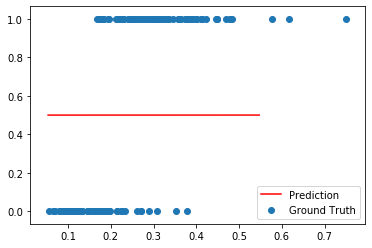

(Epoch 0 / 25000) train loss: 0.692963; val_loss: 0.692906
(Epoch 1000 / 25000) train loss: 0.579992; val_loss: 0.580230
(Epoch 2000 / 25000) train loss: 0.513267; val_loss: 0.516000
(Epoch 3000 / 25000) train loss: 0.470374; val_loss: 0.474992
(Epoch 4000 / 25000) train loss: 0.440844; val_loss: 0.446894
(Epoch 5000 / 25000) train loss: 0.419440; val_loss: 0.426625
(Epoch 6000 / 25000) train loss: 0.403307; val_loss: 0.411429
(Epoch 7000 / 25000) train loss: 0.390774; val_loss: 0.399695
(Epoch 8000 / 25000) train loss: 0.380800; val_loss: 0.390418
(Epoch 9000 / 25000) train loss: 0.372706; val_loss: 0.382945
(Epoch 10000 / 25000) train loss: 0.366032; val_loss: 0.376830
(Epoch 11000 / 25000) train loss: 0.360453; val_loss: 0.371761
(Epoch 12000 / 25000) train loss: 0.355737; val_loss: 0.367513
(Epoch 13000 / 25000) train loss: 0.351709; val_loss: 0.363921
(Epoch 14000 / 25000) train loss: 0.348242; val_loss: 0.360857
(Epoch 15000 / 25000) train loss: 0.345233; val_loss: 0.358227
(Epoc

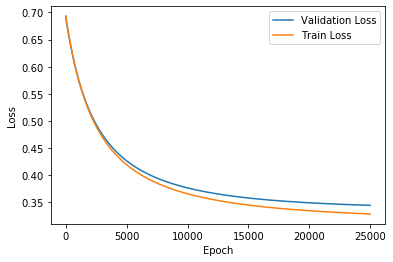

Accuracy AFTER training 91.5%


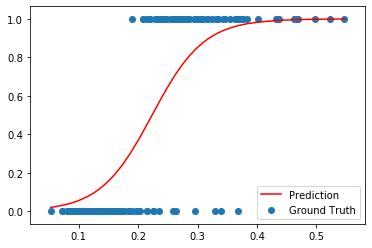

In [11]:
from exercise_code.solver import Solver
from exercise_code.networks.utils import test_accuracy
from exercise_code.networks.classifier import Classifier


# Select the number of features, you want your task to train on.
# Feel free to play with the sizes.
num_features = 1

# initialize model and weights
model = Classifier(num_features=num_features)
model.initialize_weights()

y_out, _ = model(X_test)

accuracy = test_accuracy(y_out, y_test)
print("Accuracy BEFORE training {:.1f}%".format(accuracy*100))


if np.shape(X_val)[1]==1:
    plt.scatter(X_val, y_val, label = "Ground Truth")
    inds = X_test.flatten().argsort(0)
    plt.plot(X_test[inds], y_out[inds], color='r', label = "Prediction")
    plt.legend()
    plt.show()

data = {'X_train': X_train, 'y_train': y_train,
        'X_val': X_val, 'y_val': y_val}

# We are going to use the BCE loss for this task.
loss = BCE()

# Please use these hyperparmeter as we also use them later in the evaluation
learning_rate = 1e-1
epochs = 25000

# Setup for the actual solver that's going to do the job of training
# the model on the given data. set 'verbose=True' to see real time 
# progress of the training.
solver = Solver(model, 
                data, 
                loss,
                learning_rate, 
                verbose=True, 
                print_every = 1000)

# Train the model, and look at the results.
solver.train(epochs)
plt.plot(solver.val_loss_history, label = "Validation Loss")
plt.plot(solver.train_loss_history, label = "Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend() 
plt.show() 

# Test final performance
y_out, _ = model(X_test)

accuracy = test_accuracy(y_out, y_test)
print("Accuracy AFTER training {:.1f}%".format(accuracy*100))

if np.shape(X_test)[1]==1:

    plt.scatter(X_test, y_test, label = "Ground Truth")
    inds = X_test.argsort(0).flatten()
    plt.plot(X_test[inds], y_out[inds], color='r', label = "Prediction")
    plt.legend()
    plt.show()
    

### Save your BCELoss, Classifier and Solver for Submission
Simply save your objects using the following cell. This will save them to a pickle file `models/logistic_regression.p`.

In [12]:
from exercise_code.tests import save_pickle

save_pickle(
    data_dict={
        
        "BCE_class": BCE,
        "Classifier_class": Classifier,
        "Solver_class": Solver
    },
    file_name="logistic_regression.p"
)

# Submission Instructions

Now, that you have completed the neccessary parts in the notebook, you can go on and submit your files.

1. Go on [our submission page](https://dvl.in.tum.de/teaching/submission/), register for an account and login. We use your matriculation number and send an email with the login details to the mail account associated. When in doubt, login into tum online and check your mails there. You will get an id which we need in the next step.
2. Navigate to `exercise_code` directory and run the `create_submission.sh` file to create the zip file of your model. This will create a single `zip` file that you need to upload. Otherwise, you can also zip it manually if you don't want to use the bash script.
3. Log into [our submission page](https://dvl.in.tum.de/teaching/submission/) with your account details and upload the `zip` file. Once successfully uploaded, you should be able to see the submitted "dummy_model.p" file selectable on the top.
4. Click on this file and run the submission script. You will get an email with your score as well as a message if you have surpassed the threshold.

# Submission Goals

- Goal: Successfully implement a classifier, a BCE loss function and a solver that can perform gradient descent and finally the model can predict the given dataset with an accuracy higher than 85%.
- Test cases:
  1. Does `forward()` and `backward()` of your classifier return the correct value and data type?
  2. Does `forward()` and `backward()` of your BCE loss return the correct value and data type?
  3. Does your `solver.train()` train the model that it achieves a prediction accuracy of your model beyond the given threshold accuracy of 85%? We train your classifier model with new initialised weights, lr = 0.1 and 25000 epochs on a 1-D classification problem.
- Reachable points [0, 100]: 0 if not implemented, 100 if all tests passed, 33.3 per passed test
- Threshold to clear exercise: 80
- Submission start: __May 14, 2020 12.00__
- Submission deadline : __May 20, 2020 23.59__ 
- You can make multiple submission uptil the deadline. Your __best submission__ will be considered for bonus
